# Imports & globals

In [1]:
import sys
sys.path.append("/home/cbarkhof/fall-2021")

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from analysis_run_postprocessing.general_postprocessing_steps import *
from latent_analysis import plot_latents

import pandas as pd
import numpy as np
import torch

In [3]:
DEVICE = "cuda:0"
EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
ENCODING_FILE = "encodings.pt"

# Fetch overview relevant runs

In [4]:
prefixes = ["(mdr-vae-exp 8 oct)", "(fb-vae-exp 8 oct) ", 
            "(beta-vae-exp 6 oct) ", "(inf-vae-exp 5 oct) ", 
            "(5-jan ptb-test)", "(4-jan ptb-test)"]

run_df = make_run_overview_df(prefixes=prefixes)
print(len(run_df))
run_df.head()

94


,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1000 dec: Weak-M roBERTa,INFO-VAE,0.1,ptb,language,0,0,0,1000,weak_memory_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 1000 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0,0,0,1000,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Weak-M roBERTa,INFO-VAE,0.1,ptb,language,0,0,0,100,weak_memory_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0,0,0,100,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 1 l_MMD 10 dec: Weak-M roBERTa,INFO-VAE,1,ptb,language,0,0,0,10,weak_memory_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=1.0, l_2_mm..."


In [5]:
missing_df = overview_of_missing_analysis(run_df)
print(len(missing_df))
missing_df.sum()

94


dir                0
surprisal_data     0
encode             0
samples           49
cond_samples      50
evaluation         0
dtype: int64

# Gather encodings for relevant runs from disk

In [6]:
all_encodings = dict()

for image_or_language, group_df in run_df.groupby("image_or_language"):
    
    all_encodings[image_or_language] = dict()
    
    for i, (clean_name, row) in enumerate(group_df.iterrows()):
        p = f"{EXPORT_DIR}/{row.run_name}/{ENCODING_FILE}"

        encodings = torch.load(p)
        encodings = encodings["valid"]

        if i == 0:
            for k, v in encodings.items(): print(k, v.shape)

        encodings["run_name"] = row.run_name

        all_encodings[image_or_language][clean_name] = encodings

z torch.Size([10000, 10])
mean torch.Size([10000, 10])
scale torch.Size([10000, 10])
z torch.Size([3370, 32])
mean torch.Size([3370, 32])
scale torch.Size([3370, 32])


# Plot

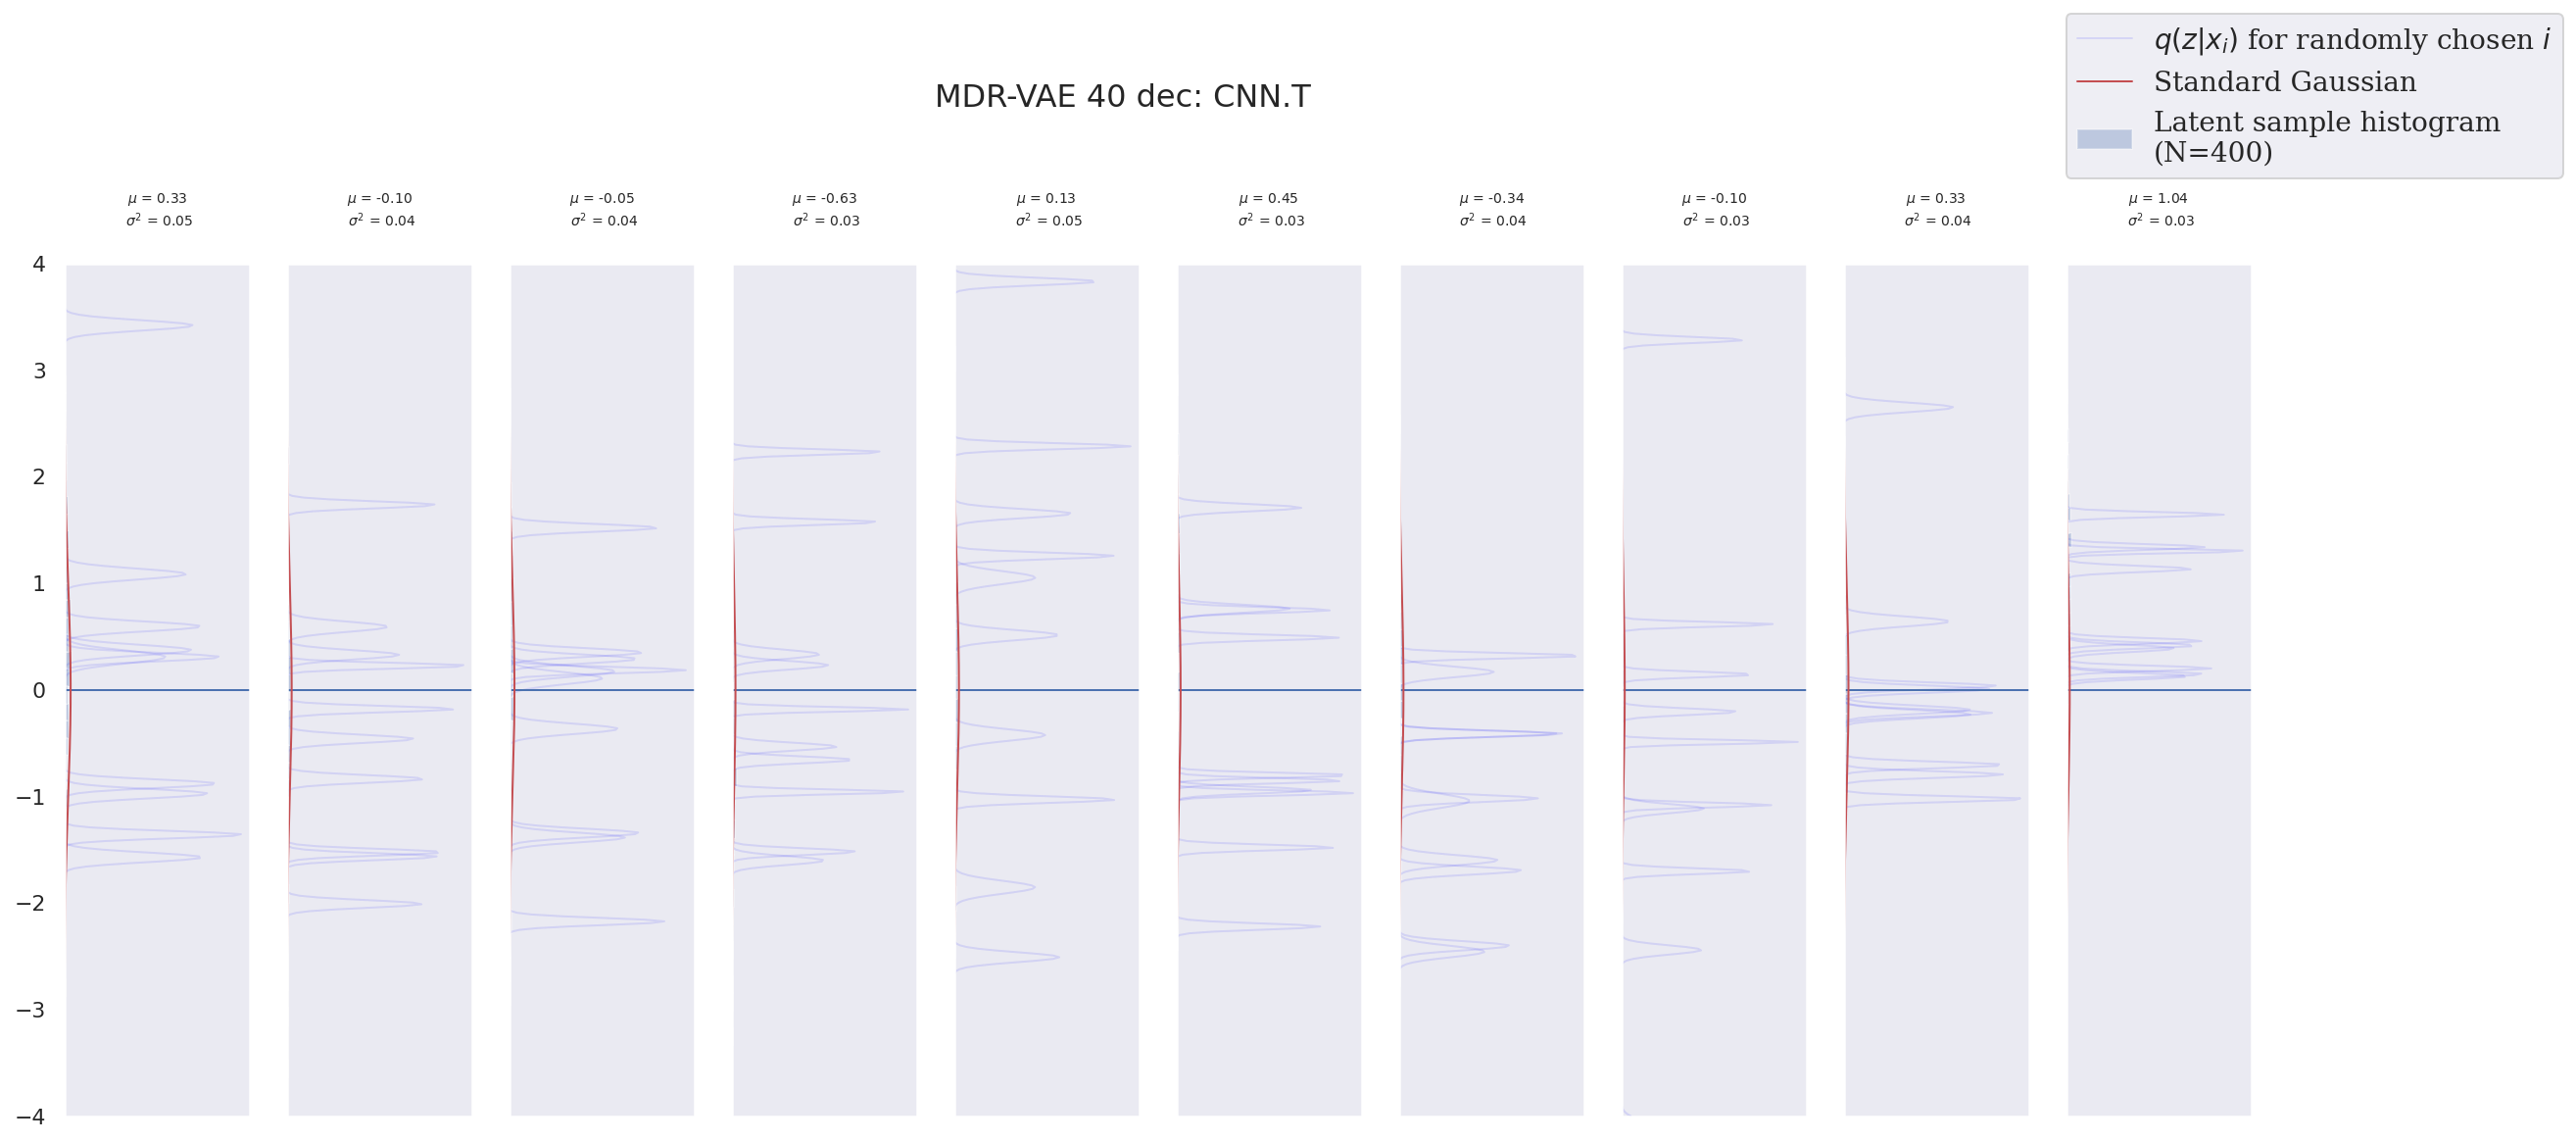

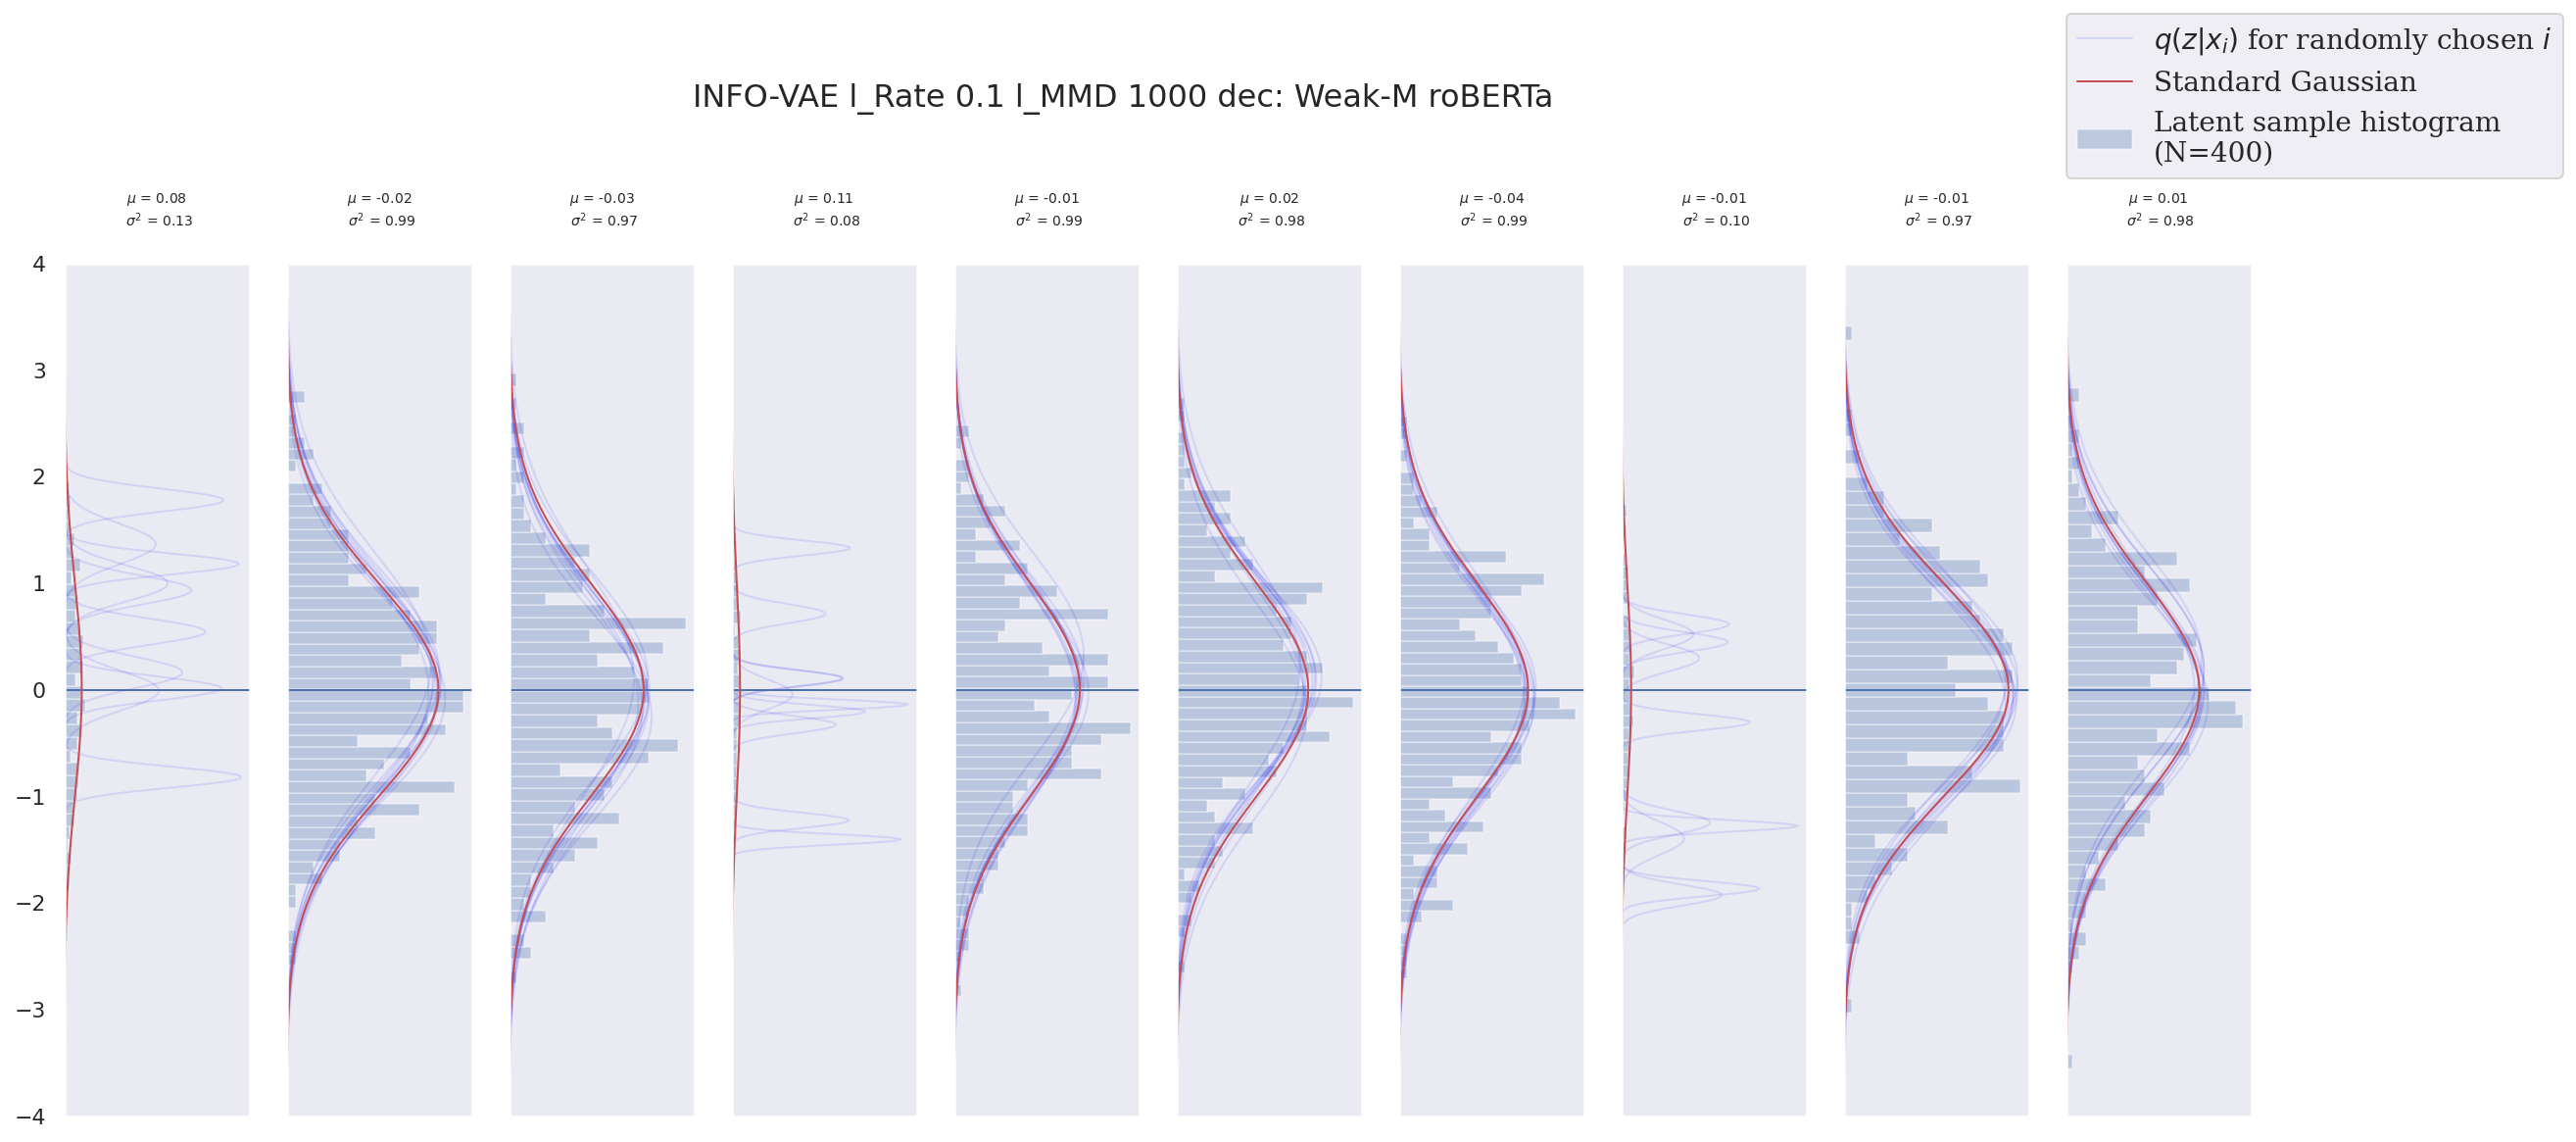

In [7]:
for image_or_language in ["image", "language"]:
    for i, (clean_name, encodings) in enumerate(all_encodings[image_or_language].items()):

        plot_latents(encodings, clean_name, plot_N_sep_posteriors=10, plot_N_encodings=400)

        if i == 0: break

# Compute some statistics (Kolgomorov-Smirnov, MMD and rate)

In [8]:
from analysis.bda_models.bda_MM_latent_analysis import *

language_encoding_stats = gather_alternative_statistics(encodings=all_encodings["language"], 
                                                        N_encodings=2000, 
                                                        latent_dim=32)

image_encoding_stats = gather_alternative_statistics(encodings=all_encodings["image"], 
                                                     N_encodings=2000, 
                                                     latent_dim=10)

SyntaxError: invalid syntax (bda_MM_latent_analysis.py, line 68)

In [ ]:
language_encoding_stats_df = pd.DataFrame(language_encoding_stats).transpose()
image_encoding_stats_df = pd.DataFrame(image_encoding_stats).transpose()

display(language_encoding_stats_df.head())
display(image_encoding_stats_df.head())

In [ ]:
sns.pairplot(image_encoding_stats_df)
sns.pairplot(language_encoding_stats_df)

# Mixed Membership analysis for language

In [ ]:
mm_language_data, mm_language_group_names = prepare_data(encoding_dict=all_encodings["language"], 
                                                         N_encodings=1000, 
                                                         latent_dim=32, 
                                                         device="cuda:0")

MM_language = MixedMembershipLatentAnalysis(run_names=mm_language_group_names, 
                                            all_latents=mm_language_data.permute(1, 0, 2), 
                                            device=DEVICE, 
                                            seed=0, 
                                            num_components=6,
                                            DP_alpha=0.1)

MM_language.fit_mm(plot_elbo=True, n_iterations=600)

In [ ]:
with torch.no_grad():
    MM_language.plot_component_dist_groups(posterior_predict_n_samples=300, figsize=(7, 8))

In [ ]:
with torch.no_grad():
    marginal_kl = MM_language.approximate_marginal_kl()
language_encoding_stats_df = language_encoding_stats_df.join(pd.Series(marginal_kl).rename("mm_marginal_KL"))
sns.pairplot(language_encoding_stats_df)

# MM for image

In [ ]:
mm_image_data, mm_image_group_names = prepare_data(encoding_dict=all_encodings["image"], 
                                                   N_encodings=1000, 
                                                   latent_dim=10, 
                                                   device=DEVICE)

MM_image = MixedMembershipLatentAnalysis(run_names=mm_image_group_names, 
                                         all_latents=mm_image_data.permute(1, 0, 2), 
                                         device=DEVICE, 
                                         seed=0, 
                                         num_components=6,
                                         DP_alpha=0.1)

MM_image.fit_mm(plot_elbo=True, n_iterations=600)

In [ ]:
with torch.no_grad():
    MM_image.plot_component_dist_groups(posterior_predict_n_samples=300, figsize=(8, 8))

In [ ]:
with torch.no_grad():
    marginal_kl = MM_image.approximate_marginal_kl()
image_encoding_stats_df = image_encoding_stats_df.join(pd.Series(marginal_kl).rename("mm_marginal_KL"))
sns.pairplot(image_encoding_stats_df)